This method uses the Okubo–Weiss parameter following the method described in:
[1] https://link.springer.com/content/pdf/10.1007/s10236-013-0680-7.pdf

Limitation:
- noise in the W field
- detects an excess of eddies (Sadarjoenand Post 2000; Chaigneau et al. 2008)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook

In [3]:
plt.style.use(['science','ieee'])

Read data

In [4]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file("data2.nc")
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_x = f.variables['ugos'].data.squeeze()
vel_y = f.variables['vgos'].data.squeeze()


# fill in missing values
from common_functions import interpolate_missing_point

#imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)
#imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)
imputed_vel_x = np.ma.masked_where(np.isnan(vel_x), vel_x)[60:82,10:40]
imputed_vel_y = np.ma.masked_where(np.isnan(vel_y), vel_y)[60:82,10:40]
lat = lat[60:82]
long = long[10:40]
long.min

<function ndarray.min>

In [6]:
print(lat[0],lat[-1])
print(long[0],long[-1])

27.4375 30.0625
-28.8125 -25.1875


<IPython.core.display.Javascript object>


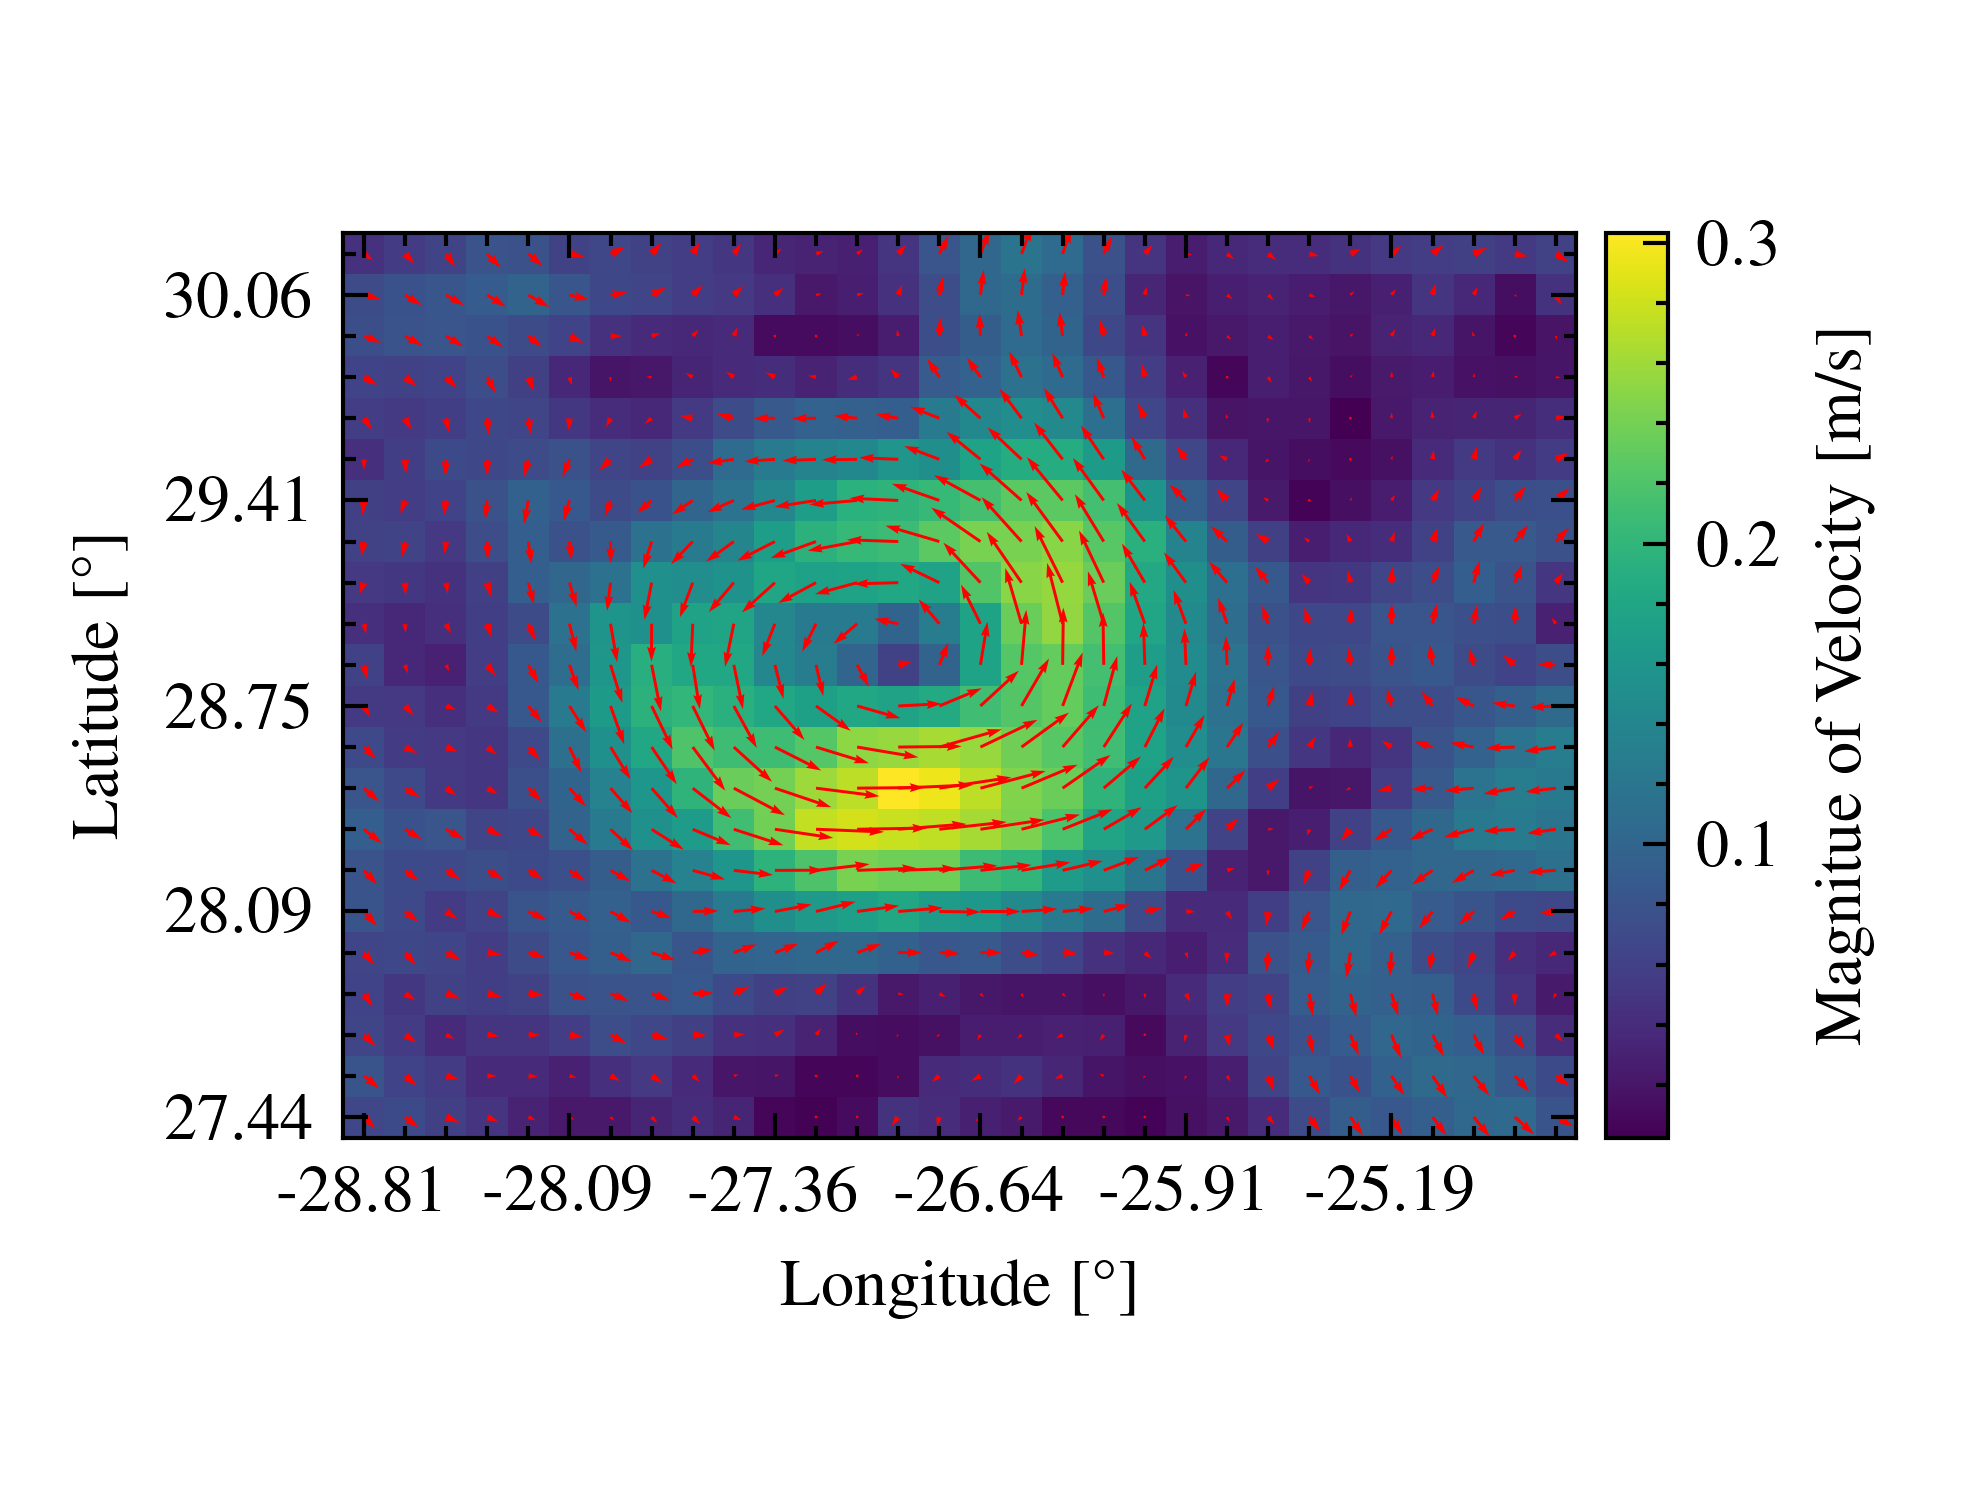

In [4]:
plt.figure()
im=plt.imshow(np.hypot(imputed_vel_x, imputed_vel_y), origin='lower')
plt.quiver(imputed_vel_x, imputed_vel_y, color='r', scale=5)
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
current_xticks = plt.gca().get_xticks()[1:-1]
plt.xticks(current_xticks, np.around(np.linspace(long.min(),long.max(), len(current_xticks)), 2))
current_yticks = plt.gca().get_yticks()[1:-1]
plt.yticks(current_yticks, np.around(np.linspace(lat.min(),lat.max(), len(current_yticks)), 2))

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Magnitue of Velocity [m/s]")

plt.tight_layout()
plt.savefig("figures/data_v_field.pdf",bbox_inches='tight')
plt.show()

## Compute the Okubo-Weiss parameter

<IPython.core.display.Javascript object>


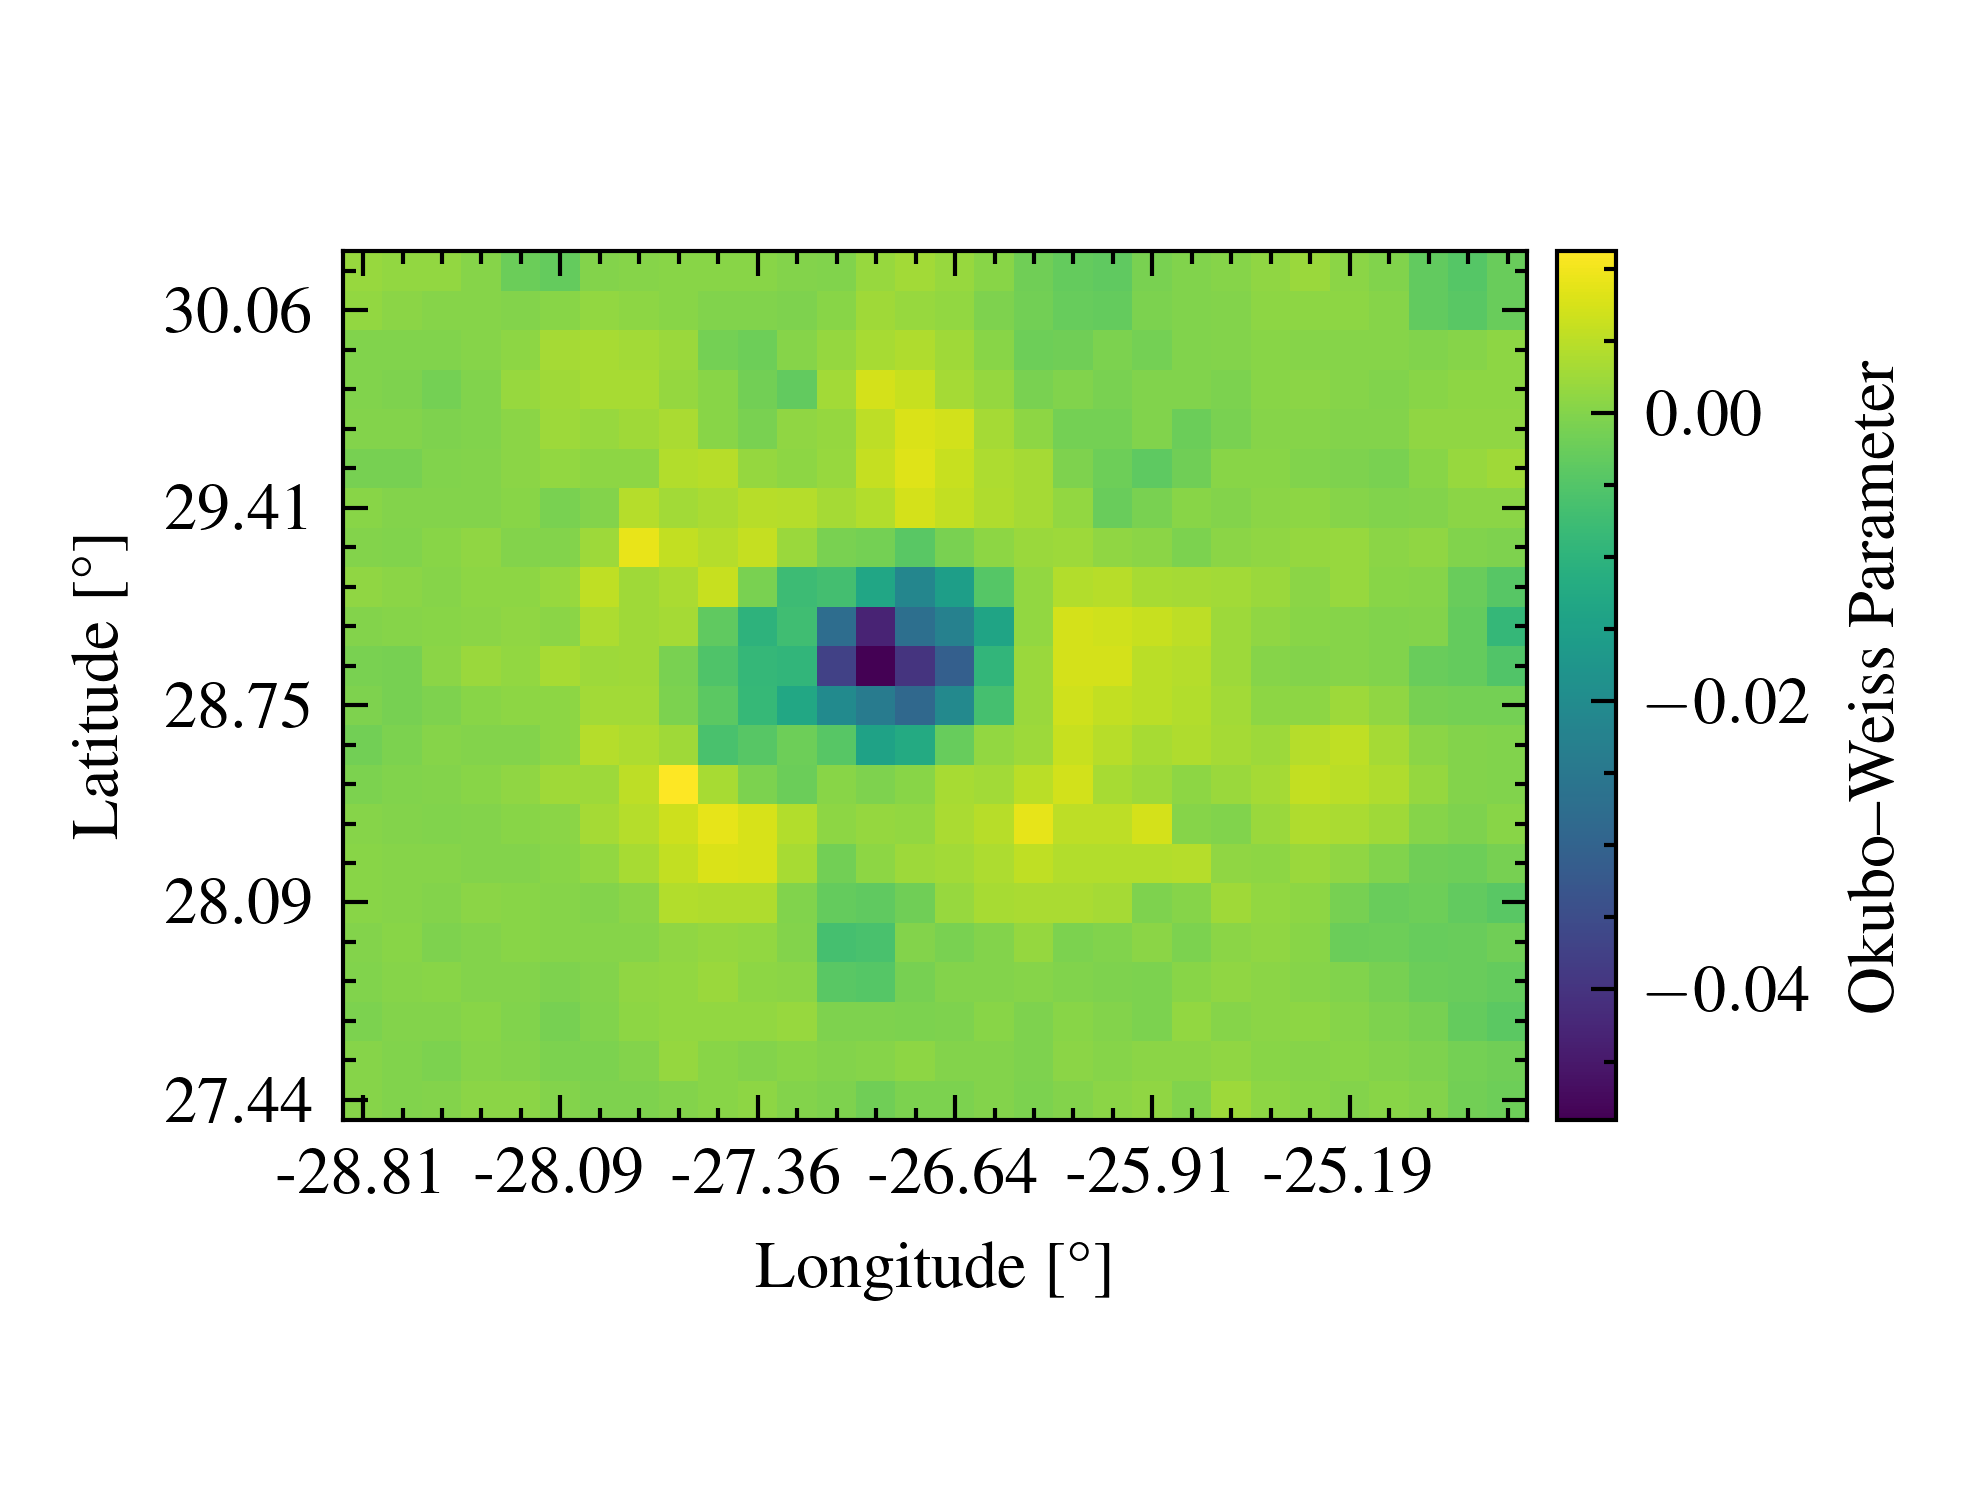

In [5]:
from common_functions import compute_okubo_weiss_parameter

W = compute_okubo_weiss_parameter(imputed_vel_x, imputed_vel_y)

plt.figure()
im=plt.imshow(W, origin='lower')
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
current_xticks = plt.gca().get_xticks()[1:-1]
plt.xticks(current_xticks, np.around(np.linspace(long.min(),long.max(), len(current_xticks)), 2))
current_yticks = plt.gca().get_yticks()[1:-1]
plt.yticks(current_yticks, np.around(np.linspace(lat.min(),lat.max(), len(current_yticks)), 2))

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Okubo–Weiss Parameter")

plt.tight_layout()
plt.savefig("figures/ow.pdf",bbox_inches='tight')
plt.show()

## Compute threshold for an Eddie

Define an Eddie as a region where $W < W_0$. The threshold is defined as $W_0 = -0.2\sigma_W$ where $\sigma_W$ is the spatial standard devation of $W$.

In [6]:
W_0 = -0.2 * np.std(W)
W_0

-0.0010721169592529927

## Threshold data

<IPython.core.display.Javascript object>


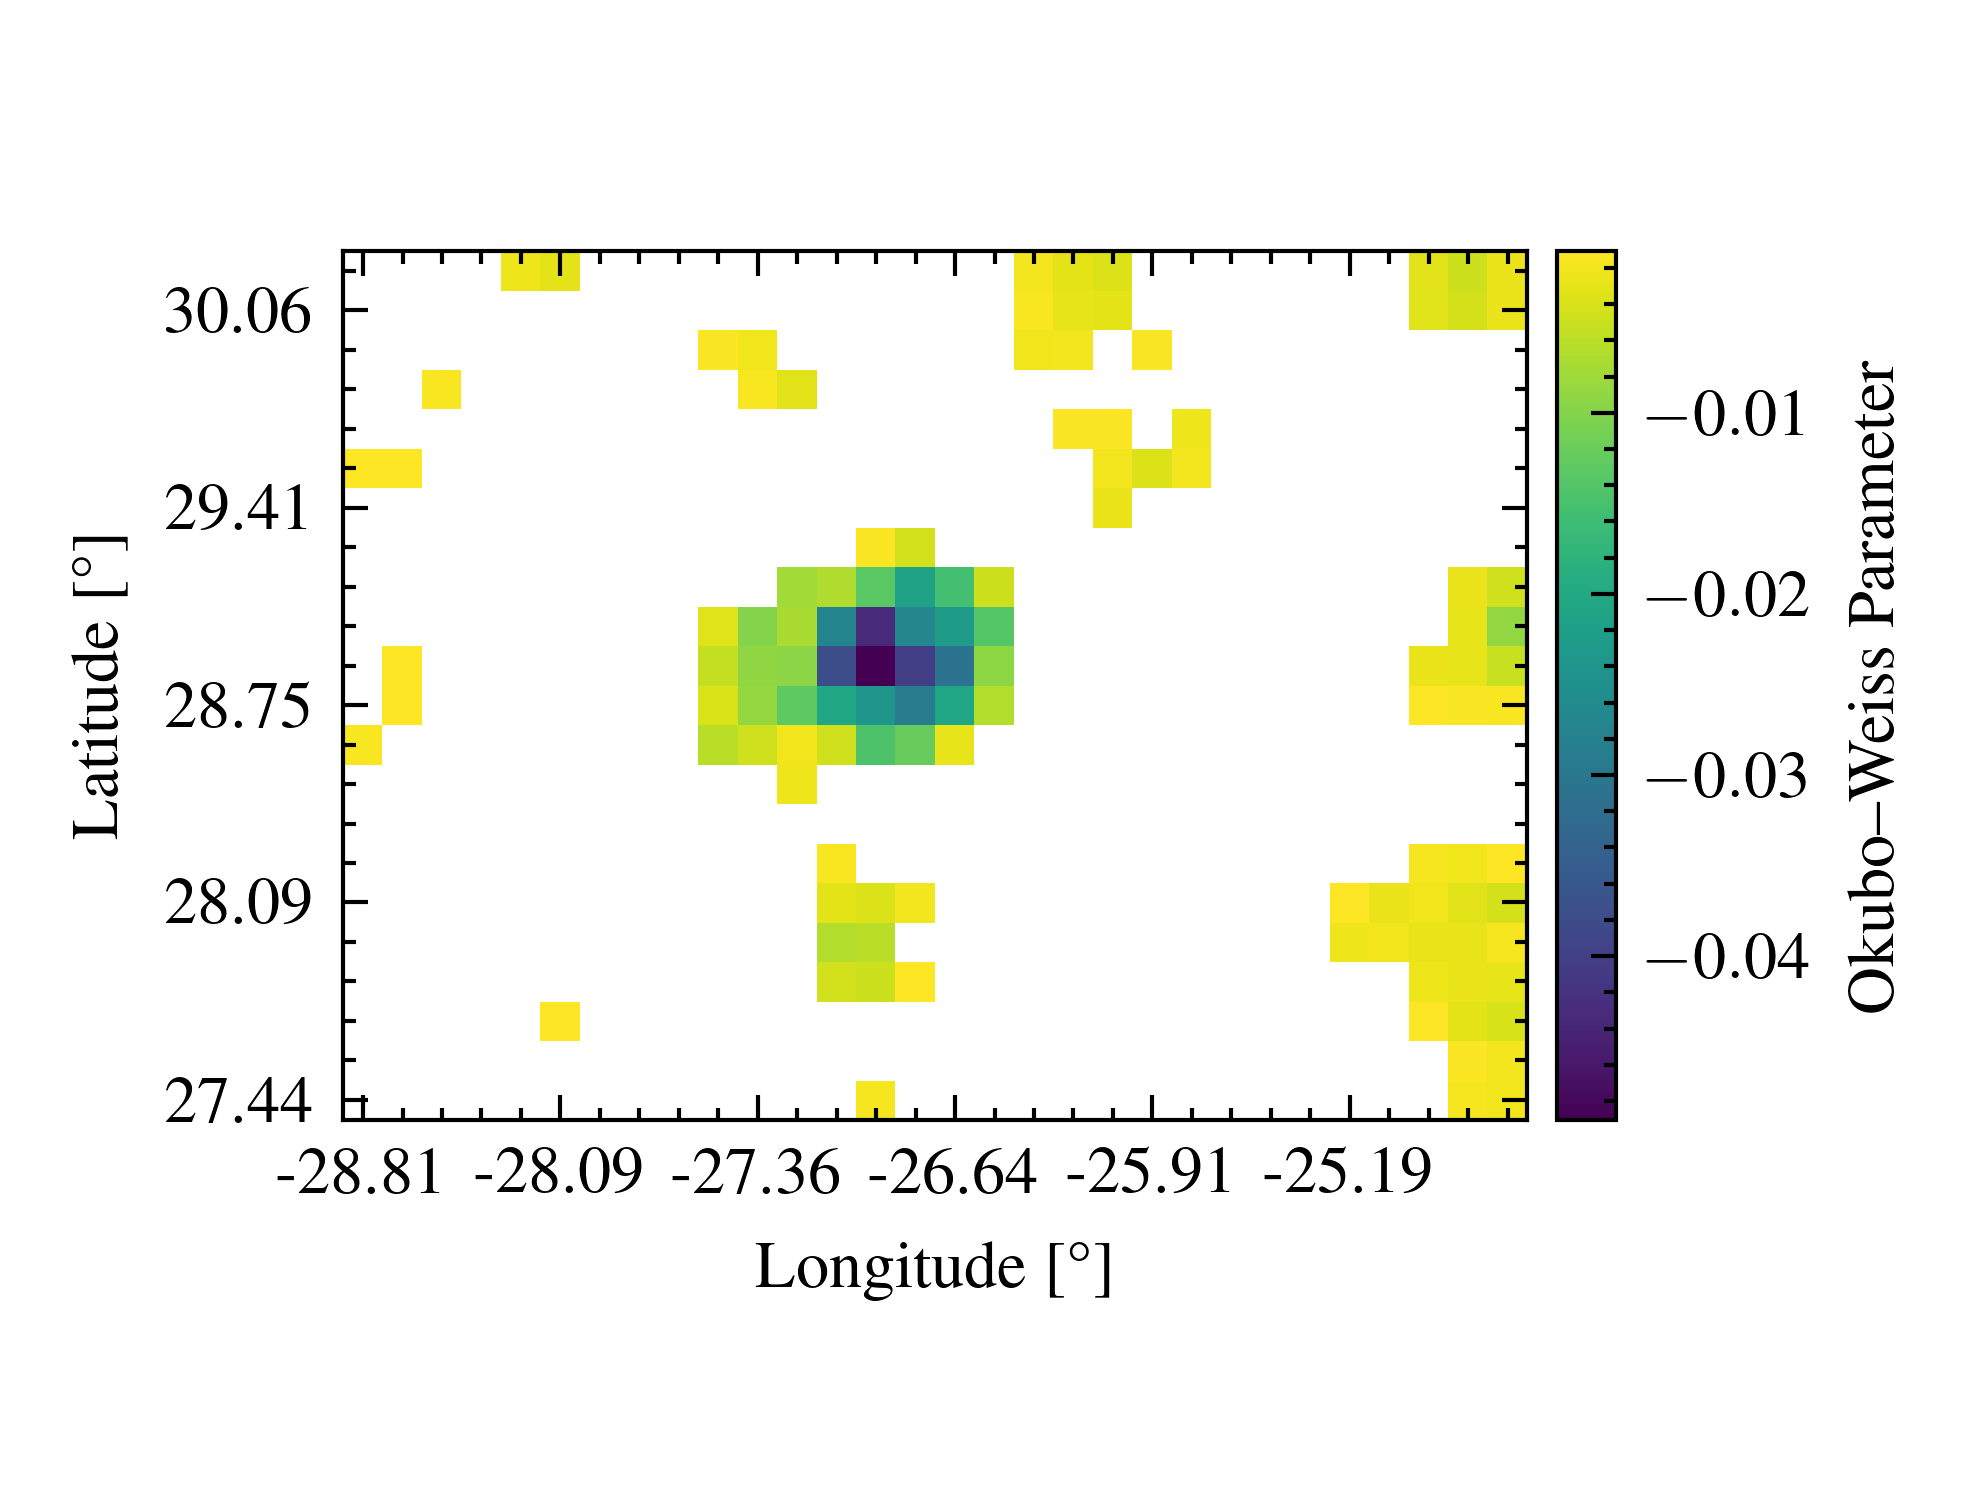

In [7]:
W_eddies = np.ma.masked_where(W > W_0, W)

plt.figure()
im=plt.imshow(W_eddies, origin="lower")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
current_xticks = plt.gca().get_xticks()[1:-1]
plt.xticks(current_xticks, np.around(np.linspace(long.min(),long.max(), len(current_xticks)), 2))
current_yticks = plt.gca().get_yticks()[1:-1]
plt.yticks(current_yticks, np.around(np.linspace(lat.min(),lat.max(), len(current_yticks)), 2))

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Okubo–Weiss Parameter")

plt.tight_layout()
plt.savefig("figures/owthres.pdf",bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


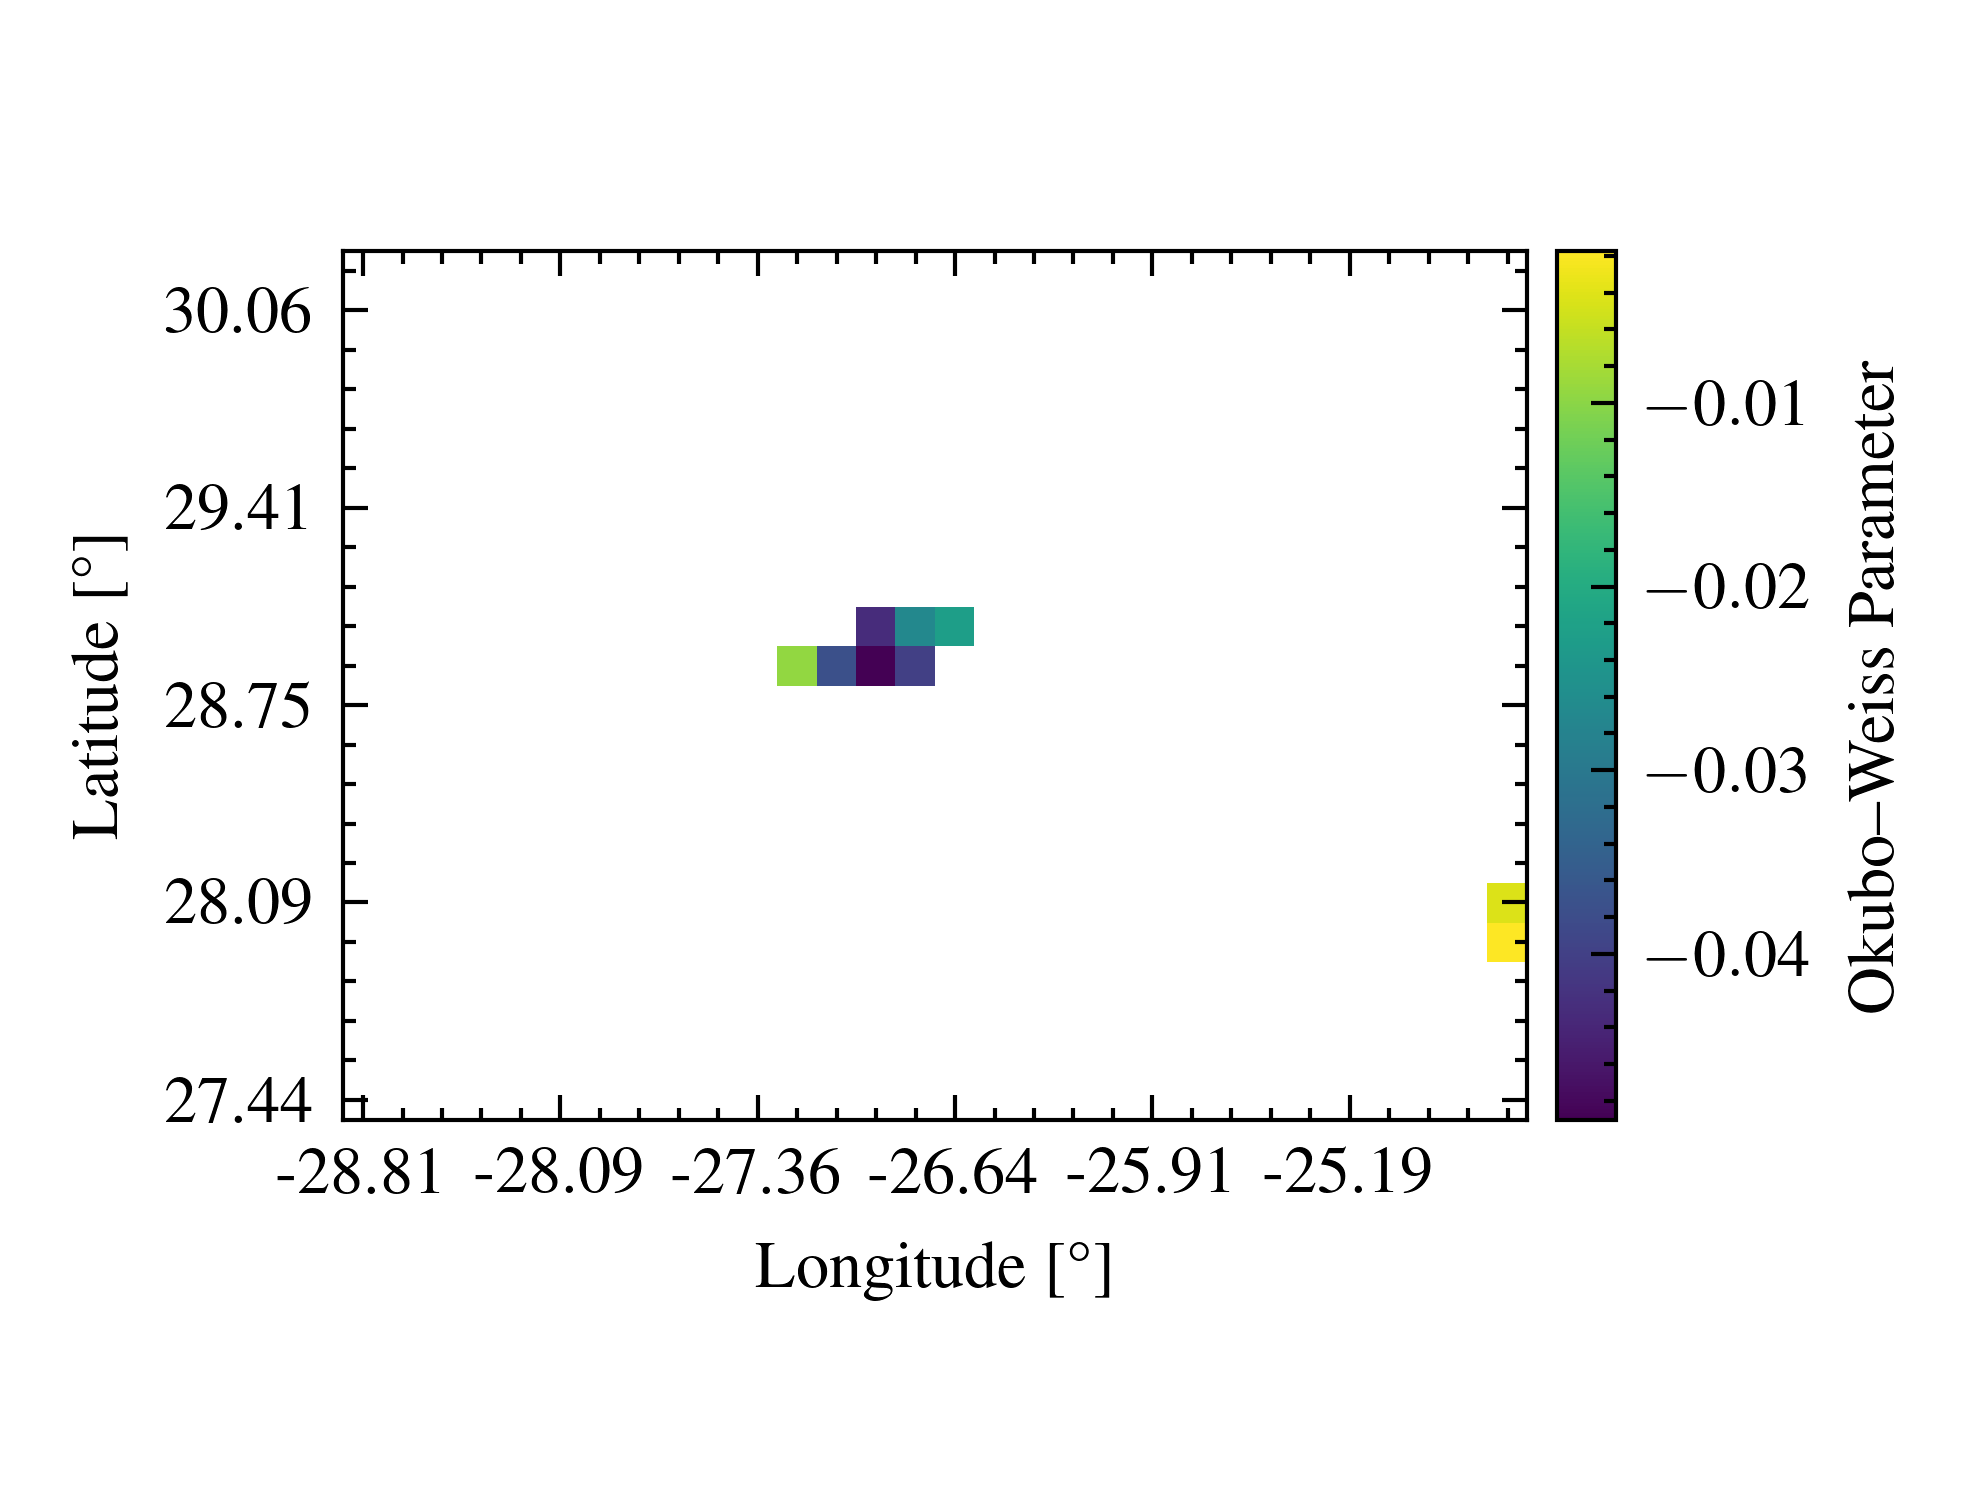

In [8]:
# here we can apply a minimum size citerion just need to decide what
W_eddies = np.ma.where(W < W_0, W, 0)
from scipy import ndimage
W_eddies = ndimage.maximum_filter(W_eddies, size=(4,4))
W_eddies = np.ma.masked_where(W_eddies == 0, W)
plt.figure()
im=plt.imshow(W_eddies, origin='lower')
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
current_xticks = plt.gca().get_xticks()[1:-1]
plt.xticks(current_xticks, np.around(np.linspace(long.min(),long.max(), len(current_xticks)), 2))
current_yticks = plt.gca().get_yticks()[1:-1]
plt.yticks(current_yticks, np.around(np.linspace(lat.min(),lat.max(), len(current_yticks)), 2))

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Okubo–Weiss Parameter")

plt.tight_layout()
plt.savefig("figures/owthresfiltered.pdf",bbox_inches='tight')
plt.show()